# VST & Noise Analysis Interactive Notebook

This notebook demonstrates the analysis of noise characteristics before and after Variance Stabilizing Transformation (VST).

**Goals:**
1.  Analyze **Input Noise** (Multiplicative Speckle) - Histogram & Distribution Fitting.
2.  Apply **VST** (Log-transform).
3.  Analyze **Transformed Noise** (Additive Gaussian) - Histogram & Distribution Fitting.
4.  Save plots and images with consistent styling.

**Note:** Ensure `data/NOISED.tiff` and `data/ORIGINAL.tiff` exist, or adjust paths below.

In [62]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output

# Project modules
from src.data_loader import ImageLoader
from src.transform import VarianceStabilizer
from src.config import AppConfig, VSTConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# --- Configuration & Styles ---
cfg = AppConfig()

# Define paths
PATH_NOISED = 'data/NOISED_2.png'
PATH_ORIGINAL = 'data/ORIGINAL_2.png'
RESULTS_DIR = cfg.export.results_dir

os.makedirs(RESULTS_DIR, exist_ok=True)

# Consistent Styling from Config
COLOR_LIN = cfg.plotting.colors['linear']  # e.g. blue
COLOR_VST = cfg.plotting.colors['vst']     # e.g. red
DPI = cfg.plotting.dpi
SAVE_FMT = cfg.plotting.save_format

print(f"Results will be saved to: {os.path.abspath(RESULTS_DIR)}")

Results will be saved to: c:\Учеба\PhD\Lukin_3_GitHub\guthub_repo\results


In [64]:
def save_plot(fig, name_suffix):
    """Helper to save plots consistently."""
    fname = f"VST_Analysis_{name_suffix}.{SAVE_FMT}"
    path = os.path.join(RESULTS_DIR, fname)
    fig.savefig(path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {fname}")

def load_images():
    try:
        img_noised = ImageLoader.load_file(PATH_NOISED)
        img_clean = ImageLoader.load_file(PATH_ORIGINAL)
        return img_clean, img_noised
    except Exception as e:
        print(f"Error loading images: {e}")
        return None, None

img_clean, img_noised = load_images()

if img_clean is not None:
    print(f"Loaded images. Shape: {img_clean.shape}")
else:
    print("Could not load images. Please check paths.")

Loaded images. Shape: (512, 512)


## 1. Input Noise Analysis (Speckle)

We calculate the noise map $N = I_{noisy} / I_{clean}$ and fit a **Gamma** distribution (common for multi-look speckle).

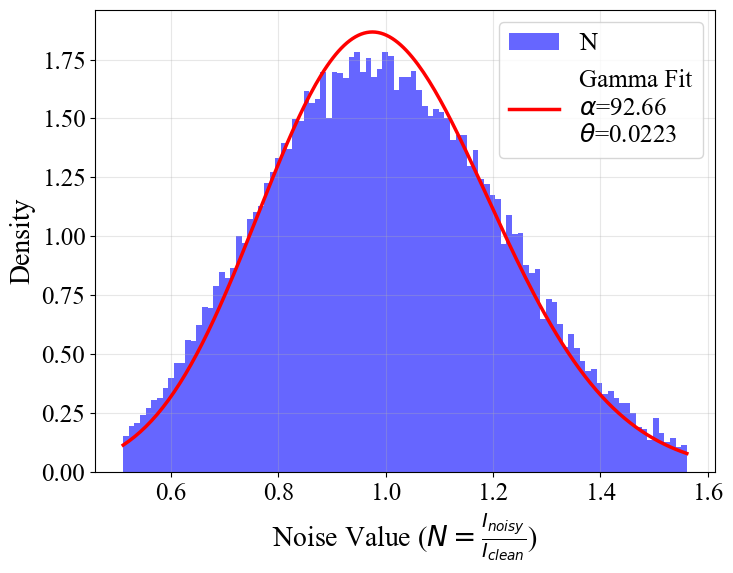

Saved: VST_Analysis_Input_Histogram_Gamma.png


In [65]:
if img_clean is not None:
    # 1. Calc Noise Map (Multiplicative)
    # Avoid division by zero
    clean_safe = np.maximum(img_clean, 1e-6)
    noise_map_input = img_noised / clean_safe
    
    # Flatten for histogram
    data_in = noise_map_input.flatten()
    # Filter outliers for better fit/plot (e.g., 1-99 percentile)
    vmin, vmax = np.percentile(data_in, 1), np.percentile(data_in, 99)
    data_in_filtered = data_in[(data_in >= vmin) & (data_in <= vmax)]
    
    # 2. Fit Distribution (Gamma)
    # Gamma PDF: f(x, a) = (x^(a-1) * exp(-x)) / Gamma(a)
    # fit returns (a, loc, scale)
    params_gamma = stats.gamma.fit(data_in_filtered)
    
    # 3. Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Histogram
    count, bins, ignored = ax.hist(data_in_filtered, bins=100, density=True, 
                                   alpha=0.6, color=COLOR_LIN, label='N')
    
    # Fitted Curve
    x_axis = np.linspace(vmin, vmax, 200)
    pdf_gamma = stats.gamma.pdf(x_axis, *params_gamma)
    
    label_fit = f"Gamma Fit\n$\\alpha$={params_gamma[0]:.2f}\n$\\theta$={params_gamma[2]:.4f}"
    ax.plot(x_axis, pdf_gamma, 'r-', linewidth=2.5, label=label_fit)
    
    # ax.set_title("Input Speckle Noise Distribution")
    ax.set_xlabel("Noise Value ($N=\\frac{I_{noisy}}{I_{clean}}$)")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()
    
    # 4. Save
    save_plot(fig, "Input_Histogram_Gamma")

## 2. VST Application

We apply the homomorphic Log-transform: $I_{log} = a \cdot \ln(I) + b$ (simplified).

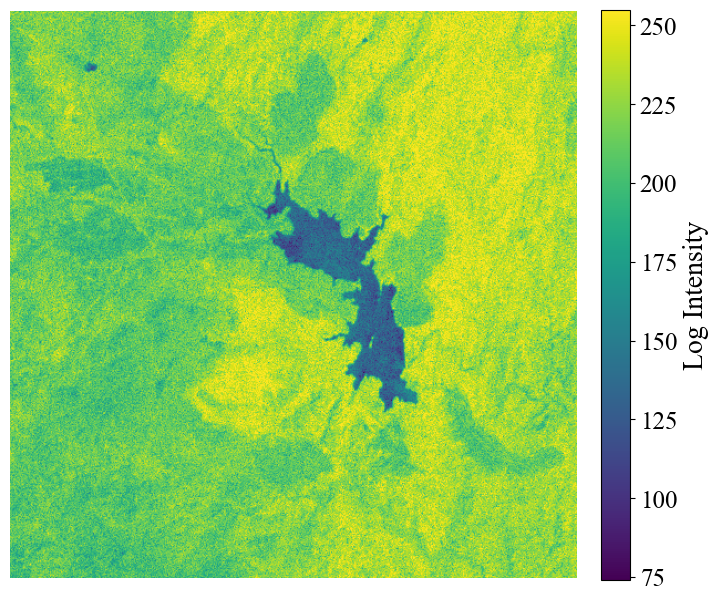

Saved: VST_Analysis_Image_VST_Log.png


In [66]:
# Config
vst_cfg = VSTConfig(a=cfg.vst.a, b=cfg.vst.b)
vst = VarianceStabilizer(vst_cfg)

# Apply transform
img_log_noised = vst.forward(img_noised)
img_log_clean = vst.forward(img_clean)

# Plot VST Image
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(img_log_noised, cmap='viridis')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Log Intensity')
# ax.set_title(f"VST Transformed Image (Log Domain)\na={vst_cfg.a}, b={vst_cfg.b}")
ax.axis('off')
plt.show()

# Save VST Image
save_plot(fig, "Image_VST_Log")

## 3. VST Noise Analysis (Gaussian)

We calculate the noise map in the log domain: $N_{log} = I_{log\_noised} - I_{log\_clean}$.
Ideally, this should be **Additive Gaussian** noise.

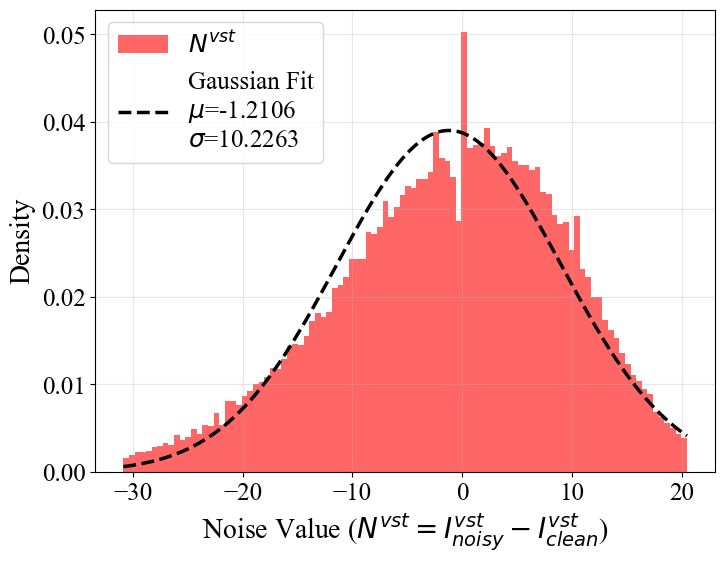

Saved: VST_Analysis_VST_Histogram_Gaussian.png


In [67]:
# 1. Calc Noise Map (Additive in Log domain)
noise_map_vst = img_log_noised - img_log_clean

# Flatten
data_vst = noise_map_vst.flatten()

# Filter outliers
vmin, vmax = np.percentile(data_vst, 1), np.percentile(data_vst, 99)
data_vst_filtered = data_vst[(data_vst >= vmin) & (data_vst <= vmax)]

# 2. Fit Distribution (Normal)
mu, std = stats.norm.fit(data_vst_filtered)

# 3. Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
count, bins, ignored = ax.hist(data_vst_filtered, bins=100, density=True, 
                               alpha=0.6, color=COLOR_VST, label='$N^{vst}$')

# Fitted Curve
x_axis = np.linspace(vmin, vmax, 200)
pdf_norm = stats.norm.pdf(x_axis, mu, std)

label_fit = f"Gaussian Fit\n$\mu$={mu:.4f}\n$\sigma$={std:.4f}"
ax.plot(x_axis, pdf_norm, 'k--', linewidth=2.5, label=label_fit)

# ax.set_title("VST Noise Distribution (Log Domain)")
ax.set_xlabel("Noise Value ($N^{vst}=I_{noisy}^{vst}-I_{clean}^{vst}$)")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

# 4. Save
save_plot(fig, "VST_Histogram_Gaussian")